In [1]:
from IPython.display import Image

# Directions

The slide below shows you where we have come from, and where we are heading in the remaining classes.

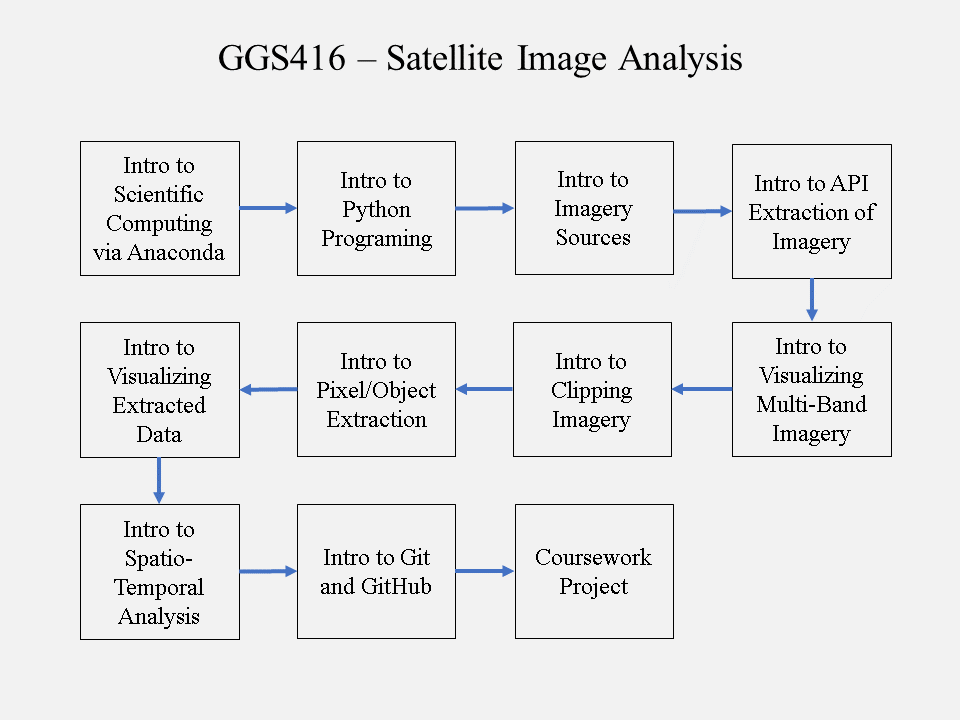

In [2]:
Image("images/overview.png")

# Introductory Pixel/Object Extraction

In this tutorial we are going to cover an object detection and extraction example. 

We will use a basic approach, thus we won't use any advanced statistics/machine learning at this stage. 

The learning outcomes will be:

- Image visualization basics.
- Introductory pixel identification/object extraction in satellite imagery.
- Conversion of pixels to shapes and extraction. 

Let's first import and inspect an image we will use for this tutorial. This is a quicker way than loading each individual band separately.  

We need to import a few packages:

In [3]:
# Example
import rasterio
from rasterio.plot import show
from rasterio.features import shapes
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

The image location is the Shenandoah River, in the Shenandoah Valley. 

See the file 'shenandoah_valley.tif'.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


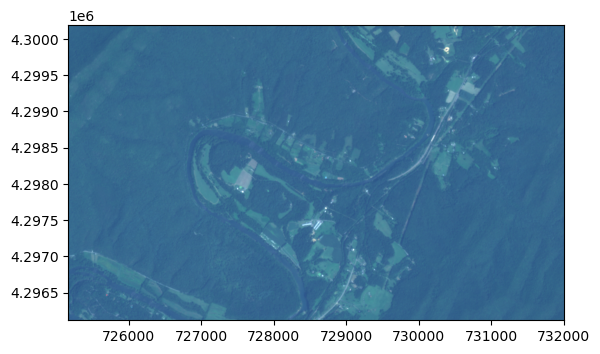

<AxesSubplot:>

In [6]:
# Example
# Open our image as a rasterio object
my_raster_image = rasterio.open('shenandoah_valley.tif')

## Planet PSScene image: https://developers.planet.com/docs/data/psscene/
## Order is blue, green, red, infrared
## Thus here for a red-green-blue true color composite, we reorder as 3,2,1.
## Also, scaling is similar to matplotlib, so values need to be between 0-1.
rasterio.plot.show(
    my_raster_image.read([3,2,1]) / 7000, 
    transform=my_raster_image.transform
)

As we will need our multi-band layers for actual pixel/image extraction part, let us separate them out (as we did in previous classes).

In [8]:
# Example
## Planet PSScene image: https://developers.planet.com/docs/data/psscene/
## Order is blue, green, red, infrared
## Thus here for a red-green-blue true color composite, we reorder as 3,2,1.
red = np.float32(my_raster_image.read(3))
green = np.float32(my_raster_image.read(2))
blue = np.float32(my_raster_image.read(1))
nir = np.float32(my_raster_image.read(4))
nir

array([[6892., 6810., 6809., ..., 7315., 7118., 6978.],
       [6755., 6684., 6688., ..., 6734., 6870., 6982.],
       [6809., 6672., 6647., ..., 6452., 6755., 6930.],
       ...,
       [6731., 7136., 7312., ..., 7225., 7076., 6778.],
       [6829., 7092., 7498., ..., 6757., 6554., 6476.],
       [6493., 6616., 7284., ..., 6168., 6147., 6304.]], dtype=float32)

Next, the aim is to extract certain pixels and not others, based on the underlying values.

Therefore, we will need a new array, which here we will call `water_index` (as we're going to extract water features).

In [10]:
# Example
# Create a new empty numpy array of zeros.#
water_index = np.zeros(nir.shape)
water_index

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Next, we will do the pixel/image extraction part. 

You can evaluate the content on this page for a bit of background:

https://developers.planet.com/docs/planetschool/satellite-imagery/

*Anyway, an image contains some combination of bands, or data “layers”, that represent each of the different wavelengths of light recorded by the sensor. Planet’s satellites record red, green, blue, and near-infrared (NIR) light reflecting off the ground. Even though our eyes don't see it, near-infrared (NIR) light provides extremely helpful information! Our RapidEye images capture NIR as well as red edge information, which falls between "pure" red and NIR. People are most familiar with RGB images, because that’s what we see out in the world. You can see where visible light appears in the electromagnetic spectrum in the figure below.*

Importantly:

*...chlorophyll reflects a lot of near-infrared (NIR) light, which means it’s useful for highlighting plants. Water absorbs NIR light, so it’s easy to distinguish green water from green plants.*

As water absorbs NIR light, we can use this to our advantage. Below, we're going to allocate a value of 1 where the green value in each pixel is larger than the nir pixel. 

You can create any custom coding that you like here to differentiate between different pixel values or other objects. Be creative.  

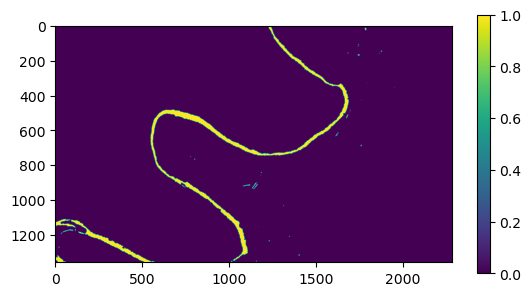

In [14]:
# Example
# Create a new empty numpy array of zeros.#
water_index = np.zeros(nir.shape)

# Now let's allocate values to our water index
# Where red is larger than green, we will apply 1
water_index[(nir < green)] = 1

# Example
plt.imshow(water_index)
plt.colorbar(shrink=0.7)

Now we have our `water_index` array, we need to convert it to a float32 data type first:

In [15]:
# Example
# Convert from float64 to float32 first
water_index = water_index.astype('float32')
water_index

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Finally, we can convert our data into actual shapes which we can then use. 

In [20]:
# Example
# Now convert the numpy array to geojson
my_shapes = shapes(water_index)
len([i for i in my_shapes])
my_shapes

<generator object shapes at 0x000001E308B38EB0>

As our coordinates are in raster pixel space, we are going to need to convert them into geographic coordinates. 

You will be able to reuse this function whenever you please. Let's define it first. 

In [10]:
# Example
def transform_coordinates(pair):
    """
    This function takes a pair of raster coordinates 
    and returns the geographic coordinates. 
    
    """
    geographic_coordinates = my_raster_image.xy(pair[1],pair[0])
    
    return geographic_coordinates

And now comes the tricky part. 

For every shape in our `my_shapes` data we're going to convert the coordinates, and then write the data to a geojson LineString. Finally, we will append each shape to a list. 

In [11]:
# Example
# Create an empty dataframe 
output = []

# Iterate over our shapes
for river_shape in my_shapes:

    # Index into our shape to get the coordinates
    # This indexing means we access:
    # - The first list in `river_shape` via [0]
    # - The coordinates values in the dictionary via ['coordinates']
    # - The first list in `coordinates` via [0]
    coords = river_shape[0]['coordinates'][0]
    
    # Transform the raster coordinates into geographic coordinates
    geographic_coords = [transform_coordinates(pair) for pair in coords]

    # Specify a geojson with our transformed coordinates
    output.append({
        'geometry' : {
            'type':'LineString',
            'coordinates': geographic_coords
            },
        'properties': {},
    }) 
        
print('Output contains {} shapes'.format(len(output)))


Output contains 63 shapes


Next, we can convert our list of dictionaries (where each dict is a geojson structure), into a geopandas dataframe using the function `gpd.GeoDataFrame.from_features()`. 

Importantly, we specify our crs as per the original image (`epsg:32617`).

Then we can write out the final shapefiles via the `to_file()` function. 

In [12]:
# Example
data_to_write = gpd.GeoDataFrame.from_features(output, crs='epsg:32617')

data_to_write.to_file('shapes/river_shape.shp')

D:\Anaconda\envs\sia\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Exercise

- Get the coordinates for Point State Park in Pittsburgh.
- Download a clear image and clip to a small area covering the Ohio, Allegheny and Monongahela Rivers. 
- Extract the water areas, so that you have a clear shapefile for the river junction.
- Overlay the shapes on the original image.
- Critically review this process and what you found (~200 words). 
- Submit for the next assignment. 
